In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import numpy as np
import pandas as pd
import scipy as sc
from scipy import sparse
from scipy.special import expit
import time, random, re
import oracles, optimization

In [3]:
t_train = pd.read_csv("toxic_train.csv")
t_test = pd.read_csv("toxic_test.csv")

### Эксперимент 1

In [4]:
t_train = t_train.drop(columns=['Unnamed: 0'])
t_test = t_test.drop(columns=['Unnamed: 0'])

In [5]:
t_train['comment_text'] = t_train['comment_text'].str.lower()
t_test['comment_text'] = t_test['comment_text'].str.lower()

In [6]:
t_train['comment_text'] = t_train['comment_text'].str.replace(r'[^a-zA-Z0-9]', ' ').str.replace(r'\s+', ' ')
t_test['comment_text'] = t_test['comment_text'].str.replace(r'[^a-zA-Z0-9]', ' ').str.replace(r'\s+', ' ')

In [7]:
# t_train.to_csv('t_train.csv', index=False)
# t_test.to_csv('t_test.csv', index=False)

### Эксперимент 2

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
vectorizer = CountVectorizer(min_df=100)

In [10]:
train_ft = vectorizer.fit_transform(t_train['comment_text'])

In [11]:
train_f = vectorizer.fit(t_train['comment_text'])

In [12]:
test_t = vectorizer.transform(t_test['comment_text'])

In [13]:
train_ft.shape

(52061, 2337)

### Эксперимент 3

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
# clf = optimization.GDClassifier(loss_function='binary_logistic', step_alpha=1,
#     step_beta=0, tolerance=1e-4, max_iter=5, l2_coef=0.1)

X = train_ft
y = np.array([1 if ist else -1 for ist in t_train['is_toxic']])
# w = np.ones((X.shape[1])) * 0.01
# history = clf.fit(X, y, w_0=np.zeros_like(w), trace=True)
# print(' '.join([str(x) for x in history['func']]))

In [16]:
alpha_list = [1, 0.5, 0.2]
beta_list = [2, 4, 6]
w_list = [np.zeros(X.shape[1])]

In [17]:
%%time
hist = []
for a in alpha_list:
    for b in beta_list:
        for w in w_list:
            clf = optimization.GDClassifier(loss_function='binary_logistic', step_alpha=a,
                step_beta=b, tolerance=1e-4, max_iter=30, l2_coef=0.1)
            start_time = time.time()
            hist.append(clf.fit(X, y, w_0=w, trace=True))
            print(f'alpha = {a}, beta = {b}, fit time = {time.time() - start_time}')

alpha = 1, beta = 2, fit time = 24.53386378288269
alpha = 1, beta = 4, fit time = 14.607996702194214
alpha = 1, beta = 6, fit time = 3.9947431087493896
alpha = 0.5, beta = 2, fit time = 29.6839702129364
alpha = 0.5, beta = 4, fit time = 7.380019426345825
alpha = 0.5, beta = 6, fit time = 5.036070346832275
alpha = 0.2, beta = 2, fit time = 18.965423107147217
alpha = 0.2, beta = 4, fit time = 4.3800578117370605
alpha = 0.2, beta = 6, fit time = 3.616501808166504
Wall time: 1min 52s


0.8614120556568862
1.413588356465274
1.503281303058153
0.6847894577233915
0.870555632247216
0.9017613441144531
0.6153422851804429
0.6431097231091383
0.64807231557232


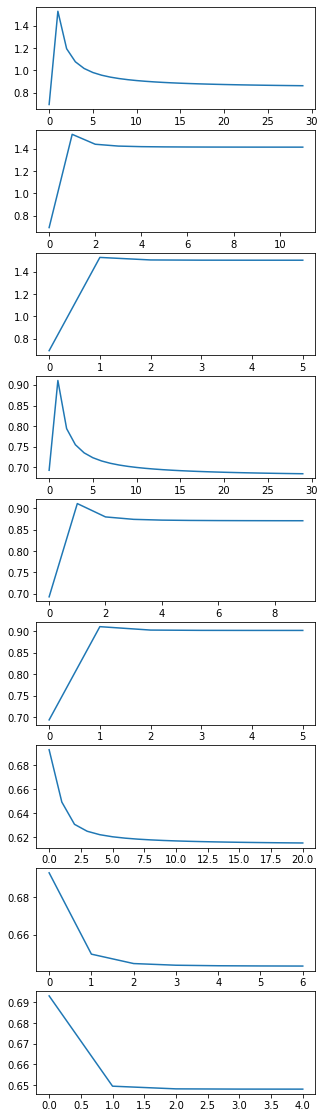

In [18]:
fig, axs = plt.subplots(len(hist), figsize=(5,20))
for i, history in enumerate(hist):
    axs[i].plot(history['func'])
    print(history['func'][-1])

Чем больше beta, тем быстрее сходится. При beta = 0, alpha = 1 очень странное поведение + переполнение в экспоненте на 10 и 20 шагах (из 30).

При alpha > 1 всё уходит в inf.

При уменьшении alpha сходится быстрее. К разным значениям...

При больших beta и малых alpha сходится к ~одному числу.

Чем быстрее сходится, тем меньше время обучения <- из-за выхода по tolerance.

Значения не зависят от размера выборки(min_df=1 or min_df=100). Меняется время обучения.

Всё вышесказанное верно для нулевого начального приближения.

Начальное приближение - единички:

всё nan (30 итераций), кроме первых двух значений. Они inf. Просто код плохой, по-поему.

Нач. приближ - 0.1:

При  а = 1 начиная с 3го значения, ф-ия inf

В остальных случаях - достаточно адекватные числа. и они даже сходятся! К разным значениям...

w0 = 0.01:

При а = 1 поведение такое же - уходит в бесконечность. Сразу

При а = 0.5 поведение, характерное для нулевого приближения

При а = 0.2 поведение как для единичек